In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sys import argv
import numpy as np
import math
from tqdm import tqdm_notebook
import datetime

In [2]:
## Variables --
train_path = 'bank_dataset/bank_train.csv'
test_path = 'bank_dataset/bank_test.csv'
validate_path = 'bank_dataset/bank_val.csv'

In [3]:
def read_data(path):
    df = pd.read_csv(path, sep=';')
    return df

In [4]:
train_data = read_data(train_path)
train_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,57,unemployed,married,secondary,no,890,no,no,cellular,5,feb,343,4,-1,0,unknown,no
1,56,technician,married,secondary,no,2558,no,no,unknown,19,jun,288,1,-1,0,unknown,no
2,50,technician,married,tertiary,no,267,yes,no,cellular,21,nov,30,1,-1,0,unknown,no
3,47,management,married,unknown,no,4567,no,no,telephone,31,jul,921,4,-1,0,unknown,no
4,49,management,married,tertiary,no,5887,no,no,cellular,2,jun,181,3,293,2,failure,yes


In [5]:
print(train_data.shape)

(36168, 17)


In [6]:
#train_data.plot(subplots = True, figsize = (10,20))

In [7]:
for col in train_data.columns:
    if col == 'balance' or col == 'duration':
        continue
    print('For col:',col)
    print(set(train_data[col].values))

For col: age
{18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95}
For col: job
{'entrepreneur', 'admin.', 'unknown', 'retired', 'self-employed', 'student', 'technician', 'blue-collar', 'services', 'housemaid', 'management', 'unemployed'}
For col: marital
{'married', 'divorced', 'single'}
For col: education
{'unknown', 'tertiary', 'secondary', 'primary'}
For col: default
{'yes', 'no'}
For col: housing
{'yes', 'no'}
For col: loan
{'yes', 'no'}
For col: contact
{'telephone', 'unknown', 'cellular'}
For col: day
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
For col: month
{'oct', 'jul', 'apr', 'sep', 'dec', 'feb', 'may', 'mar', 'aug', 'jun', 'jan', 'nov'}
For col: campaign
{

In [8]:
ohe_columns = {}
binary_columns = ['default', 'housing', 'loan']
def make_one_hot_encoding(data, cols):
    Y = data['y']
    data.drop('y', axis = 'columns', inplace = True)
    for col in cols:
        append_data = pd.get_dummies(data[col])
        ohe_columns[col] = append_data.columns
        for new_col in append_data.columns:
            data[col +'.'+ str(new_col)] = append_data[new_col]
        data.drop(col, axis = 'columns', inplace = True)
    data['y'] = Y
    for b_col in binary_columns:
        data[b_col] = data[b_col] == 'yes'
    return data

def apply_one_hot_encoding(data, cols):
    Y = data['y']
    data.drop('y', axis = 'columns', inplace = True)
    for col in cols:
        for new_col in ohe_columns[col]:
            data[col + '.' + str(new_col)] = data[col] == new_col
        data.drop(col, axis = 'columns', inplace = True)
    data['y'] = Y
    for b_col in binary_columns:
        data[b_col] = data[b_col] == 'yes'
    return data
        

In [9]:
# ohe_test_data.head()

In [10]:
# ohe_test_data.loc[ohe_test_data['age'] == 34, 'age']
# ohe_test_data['age.35'] = ohe_test_data['age'] == 34

In [11]:
# ohe_test_data

### Main reading starts from here -

In [12]:
##Read data and make one hot vectors
train_data = read_data(train_path)
n_categorical_cols = ['job', 'marital', 'education', 'contact', 'month', 'campaign', 'poutcome']
print('non categorical or biary cols',set(train_data.columns) - set(n_categorical_cols))
std_train_data = train_data.copy(deep=True)

ohe_train_data = make_one_hot_encoding(train_data, n_categorical_cols)
ohe_train_data.loc[ohe_train_data['pdays'] == -1, 'pdays'] = 999
print(std_train_data.shape)
print(ohe_train_data.shape)
ohe_train_data.head()

non categorical or biary cols {'duration', 'y', 'default', 'age', 'previous', 'housing', 'loan', 'pdays', 'balance', 'day'}
(36168, 17)
(36168, 95)


,age,default,balance,housing,loan,day,duration,pdays,previous,job.admin.,...,campaign.50,campaign.51,campaign.55,campaign.58,campaign.63,poutcome.failure,poutcome.other,poutcome.success,poutcome.unknown,y
0,57,False,890,False,False,5,343,999,0,0,...,0,0,0,0,0,0,0,0,1,no
1,56,False,2558,False,False,19,288,999,0,0,...,0,0,0,0,0,0,0,0,1,no
2,50,False,267,True,False,21,30,999,0,0,...,0,0,0,0,0,0,0,0,1,no
3,47,False,4567,False,False,31,921,999,0,0,...,0,0,0,0,0,0,0,0,1,no
4,49,False,5887,False,False,2,181,293,2,0,...,0,0,0,0,0,1,0,0,0,yes


In [13]:
test_data = read_data(test_path)
vali_data = read_data(validate_path)
std_test_data = test_data.copy(deep=True)
std_vali_data = vali_data.copy(deep=True)

ohe_test_data = apply_one_hot_encoding(test_data, n_categorical_cols)
ohe_test_data.loc[ohe_test_data['pdays'] == -1, 'pdays'] = 999
ohe_vali_data = apply_one_hot_encoding(vali_data, n_categorical_cols)
ohe_vali_data.loc[ohe_vali_data['pdays'] == -1, 'pdays'] = 999

print('test std shape       :',std_test_data.shape)
print('test ohe shape       :',ohe_test_data.shape)
print('validation std shape :',std_vali_data.shape)
print('validation ohe shape :',ohe_vali_data.shape)


test std shape       : (4521, 17)
test ohe shape       : (4521, 95)
validation std shape : (4522, 17)
validation ohe shape : (4522, 95)


### Changing numerical columns

In [14]:
numerical_cols = ['age', 'balance', 'day', 'duration','pdays', 'previous']
# data_medians = ohe_train_data[numerical_cols].median(axis = 0)
# for col in numerical_cols:
#     train_data[col] = ohe_train_data[col] > data_medians[col]
# ohe_train_data.head()

In [15]:
# numerical_cols = ['age', 'balance', 'day', 'duration','pdays', 'previous']
# medians = train_data[numerical_cols].median(axis=0)
# print(medians)

In [16]:
# # Not useful
# # Delete it
# def split_on_median(data, col):
#     med = np.median(data[col])
#     print('\n\nmedian', med)
#     #data[data[col] > med]
#     data.loc[:,col] = data.loc[:,col] > med
#     return data, med

In [17]:
def entropy(data):
    m = data.shape[0]
    negative_data = data[data['y'] == 'no'].shape[0]
    positive_data = data[data['y'] == 'yes'].shape[0]
    if negative_data == 0 or positive_data == 0:
        return 0
    ent = (positive_data/m)*np.log2(m/positive_data) + (negative_data/m)*np.log2(m/negative_data)
    return ent
# entropy(ohe_train_data)

In [18]:
std_col_val_set = {}
for col in std_train_data.columns:
    if col in numerical_cols:
        std_col_val_set[col] = [True, False]
    else:
        std_col_val_set[col] = list(set(std_train_data[col].values))
print('normal col values')
print(std_col_val_set)

ohe_col_val_set = {}
for col in ohe_train_data.columns:
    if col in numerical_cols:
        ohe_col_val_set[col] = [True, False]
    else:
        ohe_col_val_set[col] = list(set(ohe_train_data[col].values))
print('Ohe encoded col values')
print(ohe_col_val_set)

normal col values
{'age': [True, False], 'job': ['entrepreneur', 'admin.', 'unknown', 'retired', 'self-employed', 'student', 'technician', 'blue-collar', 'services', 'housemaid', 'management', 'unemployed'], 'marital': ['married', 'divorced', 'single'], 'education': ['unknown', 'tertiary', 'secondary', 'primary'], 'default': ['yes', 'no'], 'balance': [True, False], 'housing': ['yes', 'no'], 'loan': ['yes', 'no'], 'contact': ['telephone', 'unknown', 'cellular'], 'day': [True, False], 'month': ['oct', 'jul', 'apr', 'sep', 'dec', 'feb', 'may', 'mar', 'aug', 'jun', 'jan', 'nov'], 'duration': [True, False], 'campaign': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 44, 46, 50, 51, 55, 58, 63], 'pdays': [True, False], 'previous': [True, False], 'poutcome': ['failure', 'unknown', 'other', 'success'], 'y': ['yes', 'no']}
Ohe encoded col values
{'age': [True, False], 'default': [False, True]

In [19]:
def inf_gain(attr, data):
    m = data.shape[0]
    if m == 0:
        return 0
    uniq_values = None
    col_median = None
    if attr in numerical_cols:
        col_median = data[attr].median()
        uniq_values = [True, False]
    else:
        uniq_values = col_val_set[attr]
    Hs = []
    for val in uniq_values:
        sub_data = None
        if attr in numerical_cols and val:
            sub_data = data[data[attr] > col_median]
        elif attr in numerical_cols and not val:
            sub_data = data[data[attr] <= col_median]
        else:
            sub_data = data[data[attr] == val]
        if sub_data.shape[0] == 0:
            continue
        en = entropy(sub_data)
        prob = sub_data.shape[0]/m
        Hs.append(prob*en)
    return np.sum(Hs)

In [20]:
def best_attr_split(data):
    if data.shape[0] == 0:
        return None, 0
    #print('best attr data',data.shape)
    max_ig = 0
    best_attr = None
    H_y = entropy(data)
    #print('entropy of dataset', H_y)
    for col in data.columns[:-1]:
        ig = H_y - inf_gain(col, data)
        #print('Col: %-20s info gain: %f'%(col,ig))
        if max_ig < ig:
            max_ig = ig
            best_attr = col
    return best_attr, max_ig
# print(ohe_train_data[0:15])
col_val_set = ohe_col_val_set
best_attr_split(ohe_train_data[:20])

('housing', 0.1444843438056282)

In [56]:
class Node:
    total_nodes = 0
    def  __init__(self, parent, val=-1, childs = [], attr = None, split_val_parent= None, median = None):
        self.parent = parent
        self.val = val
        self.childs = childs
        self.sub_tree_size = 0
        self.attr = attr
        self.split_val_p = split_val_parent
        self.median = median
        self.prune_below = False
        self.pruning_checked = False
        Node.total_nodes += 1
    
    def __str__(self):
        l = len(self.childs)
        return 'attr:%-10s, val:%-10s, pruned?:%-5d,p_checked:%d ,#childs:%-5d'%(self.attr,str(self.val),self.prune_below,self.pruning_checked,l)

In [57]:
# std_train_data.head(15)

In [58]:
# Make Decision tree
class DecisionTree():
    def __init__(self, max_depth=20):
        self.max_depth = max_depth
        self.prediction_at_depth = []
    
    def build_tree(self, data, parent = None):
        # print('data ------------',data.shape)
        median = None
        if data.shape[0] == 0:
            return None
        Y_uniq_vals_len = len(list(set(data['y'].values)))
        y_val = data['y'].mode()[0]
        if Y_uniq_vals_len <=1:
            return Node(parent = parent, val = y_val, childs = [], attr='leaf')
        split_attr, max_ig = best_attr_split(data)
        if split_attr == None:
            print('\n\n no values to split')
            print(data.shape)
            print(data)
            return Node(parent = parent, val = y_val, childs = [], attr='leaf')
        if max_ig < 0:
            print('\n\n negative ig max')
            print(data.shape)
            print(data)
            return None

        if split_attr in numerical_cols:
            median = data[split_attr].median()
        
        values_to_split = col_val_set[split_attr]

        node = Node(parent=parent,val=y_val,childs=[],attr=split_attr, median=median)
        node.sub_tree_size = 1
        # print('Attr:',split_attr)
        for split_val in values_to_split:
            # If and elif --it's a numirical attribute, els -- for categorical
            # print('split value:',split_val)
            if median != None and split_val == True:
                # print('more than median')
                # print('median',median)
                child = self.build_tree(data[data[split_attr] > median], node)
            elif median != None and split_val == False:
                # print('less then median')
                child = self.build_tree(data[data[split_attr] <= median], node)
            else:
                # print('no categorical')
                child = self.build_tree(data[data[split_attr] == split_val], node)
            
            if child != None:
                child.split_val_p = split_val
                node.childs.append(child)
                node.sub_tree_size += child.sub_tree_size
        # print('returning for node',node)
        return node
    
    def predict_a_point(self, row, node, depth = 0, max_depth = 50, consider_pruning = False, prune_it = False):
        #print('For row  :',row.head())
        if node == None:
            print("\n\n\nNode became none-----------------------------")
            return 0
        if 'y' in row:
            pred = 1 if node.val == row['y'] else 0
            self.prediction_at_depth.append(pred)
            
        if consider_pruning and node.prune_below:
            return node.val
        
        if len(node.childs) < 1 or node.attr == 'leaf' or depth >= max_depth:
            return node.val
        attribute = node.attr
        # print('Attribute : %s'%(attribute))
    #     print('node      : %s'%(node))
        if attribute in numerical_cols:
    #         print('\tnumerical attr')
    #         print('\trows attr value : %-10s'%str(row[attribute]))
            if row[attribute] > node.median:
                return self.predict_a_point(row, node.childs[0], depth+1, max_depth, consider_pruning, prune_it)
            else:
                return self.predict_a_point(row, node.childs[1], depth+1, max_depth, consider_pruning, prune_it)
        else:
    #         print('\tnon-numerical attr')
            for child in node.childs:
    #             print('No. childs:',len(node.childs))
    #             print('\tChild:',child)
                if row[attribute] == child.split_val_p:
                    return self.predict_a_point(row, child, depth+1, max_depth, consider_pruning, prune_it)
        #print('New Attribute val found ----------------------------')
        #print('suggested value by node:', node.val)
        return node.val
    
    def predict(self,tree, data, consider_pruning = False):
        predictions = []
        depth_wise_predictions = []
        max_depth_pred = 0
        for index, row in data.iterrows():
            self.prediction_at_depth = []
            predictions.append(self.predict_a_point(row, tree, consider_pruning=consider_pruning))
            
            if len(self.prediction_at_depth) > max_depth_pred:
                max_depth_pred = len(self.prediction_at_depth)
            
            depth_wise_predictions.append(self.prediction_at_depth)
        
        depth_pred = np.zeros((len(depth_wise_predictions), max_depth_pred))
        for i in range(depth_pred.shape[0]):
            for j in range(depth_pred.shape[1]):
                if len(depth_wise_predictions[i]) > j:
                    depth_pred[i,j] = depth_wise_predictions[i][j]
                else:
                    depth_pred[i,j] = depth_pred[i,j-1]
                #print(depth_pred[i,j], end = ' ')
            #print()
        depth_wise_predictions = [0]*max_depth_pred
        for d in range(max_depth_pred):
            depth_wise_predictions[d] = sum(depth_pred[:,d])*100/data.shape[0]

        return predictions, depth_wise_predictions
    
    def set_prune_values(self, row, node, depth = 0, max_depth = 50, prune_it = False):
        #print('For row  :',row.head())
        if node == None:
            print("\n\n\nNode became none-----------------------------")
            return 0
        pred = 1 if node.val == row['y'] else 0
        self.prediction_at_depth.append(pred)
        
        if pred == 1 and not node.pruning_checked:
            #print('pruning')
            node.prune_below = True
            #print('\t',node)
            return node.val
        
        else:
            #print('rem prune')
            node.prune_below = False
            node.pruning_checked = True
        
        if len(node.childs)<1 or node.attr == 'leaf' or depth >= max_depth:
            return node.val
        
        attribute = node.attr
        
        # print('Attribute : %s'%(attribute))
    #     print('node      : %s'%(node))
        if attribute in numerical_cols:
    #         print('\tnumerical attr')
    #         print('\trows attr value : %-10s'%str(row[attribute]))
            if row[attribute] > node.median:
                return self.set_prune_values(row, node.childs[0], depth+1, max_depth)
            else:
                return self.set_prune_values(row, node.childs[1], depth+1, max_depth)
        else:
    #         print('\tnon-numerical attr')
            for child in node.childs:
    #             print('No. childs:',len(node.childs))
    #             print('\tChild:',child)
                if row[attribute] == child.split_val_p:
                    return self.set_prune_values(row, child, depth+1, max_depth)
        
        #print('New Attribute val found ----------------------------')
        return node.val
    
    def dfs_tree(self, node, d =0):
        if node != None:
            if node.prune_below == True and node.attr != 'leaf':
                print('pruned node at depth:%d'%(d))
                print(node)
        for child in node.childs:
            self.dfs_tree(child, d+1)
        return None
    
    ## Reduced Error Pruning -->
    def prune_tree(self, tree, data):
        predictions = []
        for index, row in data.iterrows():
            predictions.append(self.set_prune_values(row, tree))
        print('pruning done')
        return predictions
    
    def count_depth(self, node, d = 0,node_count=0, count_pruned = True):
        d_s = [d]
        node_count +=1
        if node.prune_below and not count_pruned:
            return d
        for child in node.childs:
            d_local = self.count_depth(child, d+1, node_count, count_pruned)
            d_s.append(d_local)
        return np.max(d_s)
        

In [59]:
import warnings
warnings.filterwarnings('ignore')

### Global Variables --

In [60]:
col_val_set = {}

### Exec to make decision Tree

In [61]:
## Standard split for each uniq categorical values
t1 = datetime.datetime.now()
d_tree = DecisionTree()
col_val_set = std_col_val_set
std_tree_root = d_tree.build_tree(std_train_data[:])
t2 = datetime.datetime.now()
print('time taken',t2-t1)



 no values to split
(4, 17)
       age         job  marital education default  balance housing loan  \
12532   33  management   single  tertiary      no       62     yes   no   
12919   34  management   single  tertiary      no      705     yes   no   
17179   50  management  married  tertiary      no      451     yes   no   
32536   60  management  married  tertiary      no     5990     yes   no   

        contact  day month  duration  campaign  pdays  previous poutcome    y  
12532  cellular   18   may       473         3     -1         0  unknown  yes  
12919  cellular    6   may       458         3     -1         0  unknown   no  
17179  cellular   14   may       441         3     -1         0  unknown   no  
32536  cellular    6   may       396         3     -1         0  unknown  yes  


 no values to split
(4, 17)
       age         job marital  education default  balance housing loan  \
23994   38  technician  single  secondary      no     1788      no   no   
28714   32  te

In [86]:
node_count =0
def count_depth(node, d = 0, count_pruned = True):
    d_s = [d]
    global node_count
    node_count +=1
    if node.prune_below and not count_pruned:
        return d
    for child in node.childs:
        d_local = count_depth(child, d+1, count_pruned)
        d_s.append(d_local)
    return np.max(d_s)

l_depth = count_depth(std_tree_root, count_pruned=False)
print(node_count, l_depth)

5478 17


In [77]:
t1 = datetime.datetime.now()
d_tree = DecisionTree()
col_val_set = ohe_col_val_set
ohe_tree_root = d_tree.build_tree(ohe_train_data[:])
t2 = datetime.datetime.now()
print('time taken',t2-t1)



 no values to split
(6, 95)
       age  default  balance  housing   loan  day  duration  pdays  previous  \
5170    40    False        0    False  False    7       674    999         0   
24050   51    False      895    False  False   23       638    999         0   
24442   45    False     1201    False  False   30       652    999         0   
25935   34    False       25    False  False   11       666    999         0   
27195   32    False     -420    False  False   22       586    999         0   
33150   42    False        0    False  False   21       656    999         0   

       job.admin.  ...  campaign.50  campaign.51  campaign.55  campaign.58  \
5170            0  ...            0            0            0            0   
24050           1  ...            0            0            0            0   
24442           1  ...            0            0            0            0   
25935           1  ...            0            0            0            0   
27195           0  

### Prediction for train, test and validation set

For Normal(non ohe) train: [88.35987613359876, 88.35987613359876, 89.64001327140014, 89.79761114797611, 90.25934527759345, 91.34041141340411, 92.88044680380447, 94.15505419155055, 95.70614908206149, 97.1355894713559, 98.38531298385313, 99.13735899137359, 99.5686794956868, 99.81198849811989, 99.90599424905994, 99.96405662464056, 99.97235124972352, 99.98064587480646, 99.9834107498341]


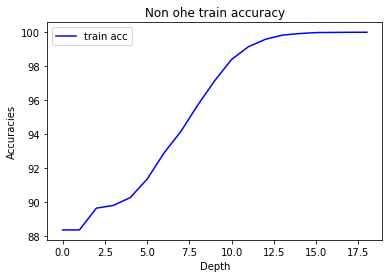

For Ohe Train: [88.35987613359876, 88.35987613359876, 89.64001327140014, 89.68701614687016, 89.70360539703606, 89.89714664897147, 90.28146427781465, 90.37823490378234, 90.82061490820615, 91.152399911524, 91.51183366511833, 91.98186241981863, 92.60119442601194, 93.23158593231587, 93.81497456314975, 94.38453881884539, 95.05363857553638, 95.67020570670206, 96.27018358770184, 96.77615571776155, 97.2489493474895, 97.685799601858, 98.08117673081176, 98.457199734572, 98.77792523777926, 99.06547224065473, 99.27007299270073, 99.49402786994028, 99.63780137137802, 99.80369387303693, 99.87558062375581, 99.93087812430878, 99.95299712452997, 99.96682149966821, 99.98064587480646, 99.9834107498341, 99.98617562486176, 99.98894049988941]


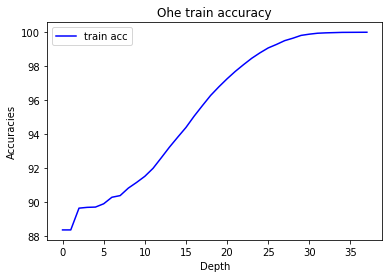

In [78]:
%timeit
_, std_train_acc = d_tree.predict(std_tree_root, std_train_data[:])
print('For Normal(non ohe) train:',std_train_acc)
fig = plt.figure()
plt.plot(std_train_acc,'-b', label = 'train acc')
plt.title("Non ohe train accuracy")
plt.xlabel("Depth")
plt.ylabel("Accuracies")
plt.legend()
plt.show()
#fig.savefig("Non_ohe_train_accuracy.png")

_, ohe_train_acc = d_tree.predict(ohe_tree_root, ohe_train_data[:])
print('For Ohe Train:',ohe_train_acc)
fig = plt.figure()
plt.plot(ohe_train_acc, '-b', label = 'train acc')
plt.title("Ohe train accuracy")
plt.xlabel("Depth")
plt.ylabel("Accuracies")
plt.legend()
plt.show()
#fig.savefig("Ohe_train_accuracy.png")

test accuracy       : [87.52488387524883, 87.52488387524883, 88.80778588807786, 88.98473788984738, 88.63083388630834, 88.96261888962619, 88.40964388409644, 88.38752488387524, 87.3921698739217, 86.81707586817076, 86.68436186684362, 86.61800486618004, 86.44105286441052, 86.41893386418934, 86.35257686352577, 86.33045786330457, 86.30833886308339, 86.33045786330457]


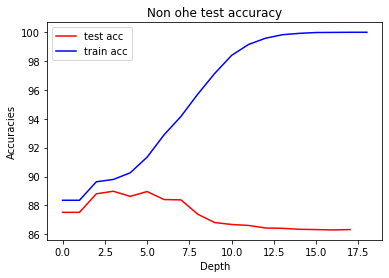

test accuracy       : [87.52488387524883, 87.52488387524883, 88.80778588807786, 88.82990488829905, 88.80778588807786, 89.33864189338642, 89.47135589471355, 89.27228489272285, 89.20592789205928, 89.11745189117453, 89.09533289095333, 89.1616898916169, 89.1395708913957, 89.00685689006856, 88.78566688785666, 88.58659588586596, 88.43176288431764, 88.07785888077859, 88.32116788321167, 88.16633488166335, 87.92302587923025, 87.8345498783455, 87.70183587701835, 87.43640787436408, 87.54700287547003, 87.21521787215218, 87.43640787436408, 87.23733687237336, 87.25945587259456, 87.19309887193099, 87.23733687237336, 87.23733687237336, 87.21521787215218, 87.21521787215218, 87.21521787215218]


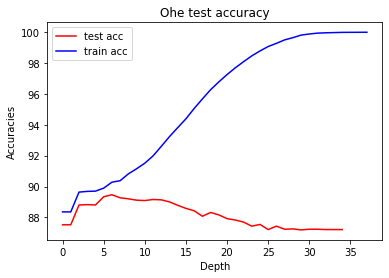

validatoin accuracy : [88.61123396727112, 88.61123396727112, 89.16408668730651, 89.20831490490933, 89.38522777532066, 88.74391862007961, 88.94294559929234, 88.65546218487395, 87.92569659442725, 87.7266696152145, 87.19593100398053, 87.21804511278195, 86.9969040247678, 86.90844758956214, 86.88633348076073, 86.88633348076073]


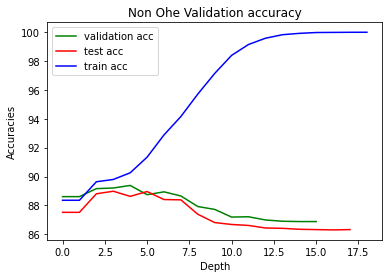

validatoin accuracy : [88.61123396727112, 88.61123396727112, 89.16408668730651, 89.27465723131358, 89.25254312251217, 89.0092879256966, 89.29677134011499, 89.47368421052632, 90.0265369305617, 89.65059708093764, 89.36311366651924, 89.62848297213623, 89.47368421052632, 89.40734188412208, 89.42945599292348, 89.34099955771782, 88.89871738168952, 88.98717381689518, 88.45643520566121, 88.54489164086688, 88.52277753206546, 88.50066342326404, 88.63334807607254, 88.30163644405131, 88.39009287925697, 88.19106590004422, 88.05838124723573, 87.90358248562583, 87.96992481203007, 87.92569659442725, 87.96992481203007, 87.92569659442725, 87.94781070322865, 87.92569659442725]


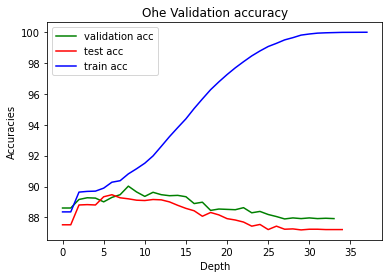

In [79]:
_, test_acc = d_tree.predict(std_tree_root, std_test_data[:])
print('test accuracy       :',test_acc)
fig = plt.figure()
plt.plot(test_acc, '-r', label = 'test acc')
plt.plot(std_train_acc,'-b', label = 'train acc')
plt.title("Non ohe test accuracy")
plt.xlabel("Depth")
plt.ylabel("Accuracies")
plt.legend()
plt.show()
#fig.savefig("Non_ohe_test_accuracy.png")

_, ohe_test_acc = d_tree.predict(ohe_tree_root, ohe_test_data[:])
print('test accuracy       :',ohe_test_acc)
fig = plt.figure()
plt.plot(ohe_test_acc, '-r', label = 'test acc')
plt.plot(ohe_train_acc, '-b', label = 'train acc')
plt.title("Ohe test accuracy")
plt.xlabel("Depth")
plt.ylabel("Accuracies")
plt.legend()
plt.show()
#fig.savefig("Ohe_test_accuracy.png")

_, std_vali_acc = d_tree.predict(std_tree_root, std_vali_data[:])
print('validatoin accuracy :', std_vali_acc)
fig = plt.figure()
plt.plot(std_vali_acc, 'g', label = 'validation acc')
plt.plot(test_acc, '-r', label = 'test acc')
plt.plot(std_train_acc,'-b', label = 'train acc')
plt.title("Non Ohe Validation accuracy")
plt.xlabel("Depth")
plt.ylabel("Accuracies")
plt.legend()
plt.show()
#fig.savefig("Non_ohe_validation_accuracy.png")

_, ohe_vali_acc = d_tree.predict(ohe_tree_root, ohe_vali_data[:])
print('validatoin accuracy :',ohe_vali_acc)
fig = plt.figure()
plt.plot(ohe_vali_acc, '-g', label = 'validation acc')
plt.plot(ohe_test_acc, '-r', label = 'test acc')
plt.plot(ohe_train_acc, '-b', label = 'train acc')
plt.title("Ohe Validation accuracy")
plt.xlabel("Depth")
plt.ylabel("Accuracies")
plt.legend()
plt.show()
#fig.savefig("Ohe_validation_accuracy.png")

### Pruning part

In [80]:
_ = d_tree.prune_tree(std_tree_root, std_vali_data[:])
_ = d_tree.prune_tree(ohe_tree_root, ohe_vali_data[:])

pruning done
pruning done


In [73]:
d_tree.dfs_tree(std_tree_root)

pruned node at depth:4
attr:balance   , val:yes       , pruned?:1    ,p_checked:0 ,#childs:2    
pruned node at depth:4
attr:balance   , val:no        , pruned?:1    ,p_checked:0 ,#childs:2    
pruned node at depth:4
attr:education , val:no        , pruned?:1    ,p_checked:0 ,#childs:2    
pruned node at depth:6
attr:loan      , val:no        , pruned?:1    ,p_checked:0 ,#childs:2    
pruned node at depth:5
attr:marital   , val:no        , pruned?:1    ,p_checked:0 ,#childs:3    
pruned node at depth:5
attr:contact   , val:no        , pruned?:1    ,p_checked:0 ,#childs:2    
pruned node at depth:6
attr:campaign  , val:yes       , pruned?:1    ,p_checked:0 ,#childs:3    
pruned node at depth:6
attr:pdays     , val:no        , pruned?:1    ,p_checked:0 ,#childs:2    
pruned node at depth:8
attr:pdays     , val:no        , pruned?:1    ,p_checked:0 ,#childs:2    
pruned node at depth:5
attr:duration  , val:no        , pruned?:1    ,p_checked:0 ,#childs:2    
pruned node at depth:6
attr:ho

Pruned Accuracy for Trained
	For standard data : [88.35987613359876, 88.35987613359876, 89.64001327140014, 89.79761114797611, 90.18745852687458, 91.04180491041805, 92.18093342180933, 92.93574430435744, 93.89239106392391, 94.69420482194205, 95.44348595443486, 95.83056845830569, 96.02687458526874, 96.12917496129175, 96.16235346162354, 96.19553196195533, 96.19829683698296, 96.20106171201061]


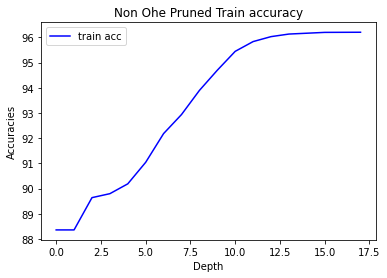

	For OHE data      : [88.35987613359876, 88.35987613359876, 89.64001327140014, 89.68701614687016, 89.70360539703606, 89.89714664897147, 90.278699402787, 90.36717540367175, 90.80402565804026, 91.09710241097102, 91.43165228931652, 91.77726166777262, 92.22793629727936, 92.65096217650962, 93.03804468038045, 93.42512718425127, 93.79285556292855, 94.17993806679938, 94.55319619553197, 94.85456757354568, 95.15593895155939, 95.3660694536607, 95.56790533067905, 95.73379783233798, 95.90245520902455, 96.0351692103517, 96.11258571112586, 96.21212121212122, 96.27571333775714, 96.3254810882548, 96.36142446361424, 96.38354346383544, 96.39736783897368, 96.40289758902898, 96.40842733908427, 96.41119221411192, 96.41395708913957, 96.41672196416722]


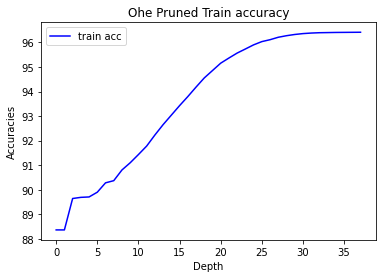

In [81]:
print('Pruned Accuracy for Trained')
_, std_pruned_train_acc = d_tree.predict(std_tree_root, std_train_data[:], consider_pruning=True)
print('\tFor standard data :',std_pruned_train_acc)

fig = plt.figure()
plt.plot(std_pruned_train_acc, '-b', label = 'train acc')
plt.title("Non Ohe Pruned Train accuracy")
plt.xlabel("Depth")
plt.ylabel("Accuracies")
plt.legend()
plt.show()
#fig.savefig("Non_ohe_pruned_train_accuracy.png")

_, ohe_pruned_train_acc = d_tree.predict(ohe_tree_root, ohe_train_data[:], consider_pruning=True)
print('\tFor OHE data      :',ohe_pruned_train_acc)

fig = plt.figure()
plt.plot(ohe_pruned_train_acc, '-b', label = 'train acc')
plt.title("Ohe Pruned Train accuracy")
plt.xlabel("Depth")
plt.ylabel("Accuracies")
plt.legend()
plt.show()
#fig.savefig("Ohe_pruned_train_accuracy.png")

Pruned Accuracy for Test
	For standard data : [87.52488387524883, 87.52488387524883, 88.80778588807786, 88.98473788984738, 88.69719088697191, 89.27228489272285, 88.85202388852024, 89.00685689006856, 88.36540588365406, 88.14421588144216, 88.07785888077859, 88.12209688122097, 88.14421588144216, 88.09997788099977, 88.07785888077859, 88.07785888077859]


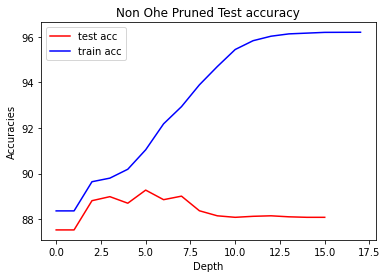

	For OHE data      : [87.52488387524883, 87.52488387524883, 88.80778588807786, 88.82990488829905, 88.80778588807786, 89.33864189338642, 89.47135589471355, 89.27228489272285, 89.18380889183808, 89.05109489051095, 89.07321389073213, 89.09533289095333, 89.20592789205928, 89.02897589028976, 88.89626188896261, 88.940499889405, 88.69719088697191, 88.52023888520239, 88.74142888741429, 88.63083388630834, 88.56447688564477, 88.47600088476001, 88.45388188453882, 88.34328688343287, 88.45388188453882, 88.34328688343287, 88.54235788542358, 88.34328688343287, 88.38752488387524, 88.38752488387524, 88.40964388409644, 88.43176288431764, 88.43176288431764, 88.43176288431764, 88.43176288431764]


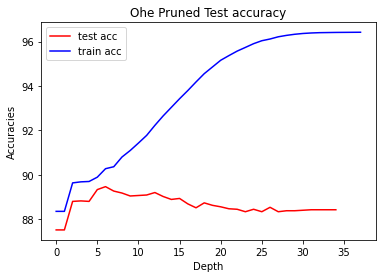

In [82]:
print('Pruned Accuracy for Test')
_, std_pruned_test_acc = d_tree.predict(std_tree_root, std_test_data[:], consider_pruning=True)
print('\tFor standard data :',std_pruned_test_acc)

fig = plt.figure()
plt.plot(std_pruned_test_acc, '-r', label = 'test acc')
plt.plot(std_pruned_train_acc, '-b', label = 'train acc')
plt.title("Non Ohe Pruned Test accuracy")
plt.xlabel("Depth")
plt.ylabel("Accuracies")
plt.legend()
plt.show()
#fig.savefig("Non_ohe_pruned_test_accuracy.png")

_, ohe_pruned_test_acc = d_tree.predict(ohe_tree_root, ohe_test_data[:], consider_pruning=True)
print('\tFor OHE data      :',ohe_pruned_test_acc)

fig = plt.figure()
plt.plot(ohe_pruned_test_acc, '-r', label = 'test acc')
plt.plot(ohe_pruned_train_acc, '-b', label = 'train acc')
plt.title("Ohe Pruned Test accuracy")
plt.xlabel("Depth")
plt.ylabel("Accuracies")
plt.legend()
plt.show()
#fig.savefig("Ohe_pruned_test_accuracy.png")

Pruned Accuracy for Validation
	For standard data : [88.61123396727112, 88.61123396727112, 89.16408668730651, 89.20831490490933, 89.4515701017249, 89.16408668730651, 89.89385227775321, 90.24767801857585, 90.07076514816453, 90.51304732419284, 90.84475895621406, 91.0216718266254, 91.15435647943387, 91.15435647943387, 91.17647058823529]


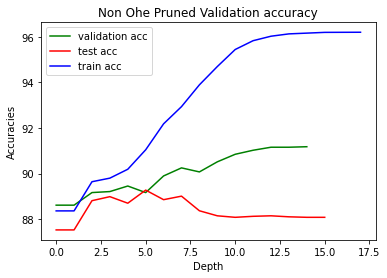

	For OHE data      : [88.61123396727112, 88.61123396727112, 89.16408668730651, 89.27465723131358, 89.25254312251217, 89.0092879256966, 89.29677134011499, 89.47368421052632, 90.0265369305617, 89.69482529854047, 89.4515701017249, 89.80539584254754, 89.91596638655462, 89.98230871295887, 90.13710747456878, 90.22556390977444, 90.0265369305617, 90.24767801857585, 89.91596638655462, 90.20344980097302, 90.35824856258293, 90.40247678018576, 90.55727554179566, 90.49093321539142, 90.62361786819991, 90.6015037593985, 90.66784608580274, 90.57938965059708, 90.6015037593985, 90.62361786819991, 90.64573197700133, 90.64573197700133, 90.64573197700133]


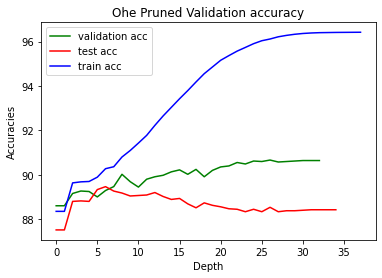

In [83]:
print('Pruned Accuracy for Validation')
_, std_pruned_vali_acc = d_tree.predict(std_tree_root, std_vali_data[:], consider_pruning=True)
print('\tFor standard data :',std_pruned_vali_acc)

fig = plt.figure()
plt.plot(std_pruned_vali_acc, '-g', label = 'validation acc')
plt.plot(std_pruned_test_acc, '-r', label = 'test acc')
plt.plot(std_pruned_train_acc, '-b', label = 'train acc')
plt.title("Non Ohe Pruned Validation accuracy")
plt.xlabel("Depth")
plt.ylabel("Accuracies")
plt.legend()
plt.show()
#fig.savefig("Non_ohe_pruned_validation_accuracy.png")

_, ohe_pruned_vali_acc = d_tree.predict(ohe_tree_root, ohe_vali_data[:], consider_pruning=True)
print('\tFor OHE data      :',ohe_pruned_vali_acc)

fig = plt.figure()
plt.plot(ohe_pruned_vali_acc, '-g', label = 'validation acc')
plt.plot(ohe_pruned_test_acc, '-r', label = 'test acc')
plt.plot(ohe_pruned_train_acc, '-b', label = 'train acc')
plt.title("Ohe Pruned Validation accuracy")
plt.xlabel("Depth")
plt.ylabel("Accuracies")
plt.legend()
plt.show()
#fig.savefig("Ohe_pruned_validation_accuracy.png")

### For Part c--

In [43]:
n_estimators = np.array(range(50, 451, 100))
print('n_ests            :',n_estimators)
max_features = np.array(range(1, 11,2))/10
print('max features      :',max_features)
min_samples_split = np.array(range(2,12,2))
print('min samples split :',min_samples_split)

n_ests            : [ 50 150 250 350 450]
max features      : [0.1 0.3 0.5 0.7 0.9]
min samples split : [ 2  4  6  8 10]


In [44]:
%%time
# also try with gini (using entropy)
d = 50
n_est = 250
min_s_s = 6
max_f = 0.5
rfc = RandomForestClassifier(n_estimators=n_est ,max_depth=d,min_samples_split=min_s_s, max_features = max_f)
cols_not_y = ohe_train_data.columns[:-1]
# print(cols_not_y)
X = ohe_train_data.loc[:,cols_not_y]
Y = ohe_train_data['y'] == 'yes'
print(X.shape, Y.shape)
rfc.fit(X,Y)

(36168, 94) (36168,)
CPU times: user 35 s, sys: 26.6 ms, total: 35 s
Wall time: 35 s


RandomForestClassifier(max_depth=50, max_features=0.5, min_samples_split=6,
                       n_estimators=250)

In [45]:
Y = ohe_vali_data['y'] == 'yes'
predict = rfc.predict(ohe_vali_data.loc[:, cols_not_y])
acc = accuracy_score(np.array(Y), np.array(predict, dtype=int))
print(acc)

0.9082264484741265


In [52]:
def part_c_random_forest():
    cols_not_y = ohe_train_data.columns[:-1]
    X_train = ohe_train_data.loc[:, cols_not_y]
    Y_train = ohe_train_data['y'] == 'yes'
    X_test  = ohe_test_data.loc[:, cols_not_y]
    Y_test  = ohe_test_data['y'] == 'yes'
    X_vali  = ohe_vali_data.loc[:, cols_not_y]
    Y_vali  = ohe_vali_data['y'] == 'yes'
    
    d = 50
    n_estimators = np.array(range(50, 451, 100))
    max_features = np.array(range(1, 11,2))/10
    min_samples_split = np.array(range(2,12,2))
    # print('n_ests            :',n_estimators)
    # print('max features      :',max_features)
    # print('min samples split :',min_samples_split)
    best_n_est    = 150
    best_max_f    = 0.5
    best_min_s_s  = 10
    best_accuracy = 0
    best_model    = None
    
    itr = 0
    for n_est in tqdm_notebook(n_estimators, total = len(n_estimators), unit = 'n_est'):
        for max_f in tqdm_notebook(max_features, total = len(max_features), unit = 'max_f'):
            for min_s_s in tqdm_notebook(min_samples_split, total = len(min_samples_split), unit = 'min_s_s'):
                rfc = RandomForestClassifier(n_estimators=n_est ,max_depth=d,min_samples_split=min_s_s, max_features = max_f, random_state=0)
                rfc.fit(X_train,Y_train)
                
                #predict_train = rfc.predict(X_train)
                #predict_test  = rfc.predict(X_test)
                predict_vali  = rfc.predict(X_vali)
                
                #train_acc = accuracy_score(np.array(Y_train), np.array(predict_train, dtype=int))
                #test_acc  = accuracy_score(np.array(Y_test) , np.array(predict_test , dtype=int))
                vali_acc  = accuracy_score(np.array(Y_vali) , np.array(predict_vali , dtype=int))
                
                if best_accuracy < vali_acc:
                    best_model = rfc
                    best_accuracy = vali_acc
                    best_n_est = n_est
                    best_max_f = max_f
                    best_min_s_s = min_s_s
                    
    predict_train = best_model.predict(X_train)
    predict_test  = best_model.predict(X_test)
    predict_vali  = best_model.predict(X_vali)

    train_acc = accuracy_score(np.array(Y_train), np.array(predict_train, dtype=int))
    test_acc  = accuracy_score(np.array(Y_test) , np.array(predict_test , dtype=int))
    vali_acc  = accuracy_score(np.array(Y_vali) , np.array(predict_vali , dtype=int))
    
    print('Best n_estimator     :', best_n_est)
    print('Best max_feature     :', best_max_f)
    print('Best min_sample_split:', best_min_s_s)
    print()
    print('Train Accuracy     :', train_acc)
    print('Test Accuracy      :', test_acc)
    print('Validation Accuracy:', vali_acc)
    
    return best_model
    

In [53]:
%%time
rfc = part_c_random_forest()

  0%|          | 0/5 [00:00<?, ?n_est/s]

  0%|          | 0/5 [00:00<?, ?max_f/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?max_f/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?max_f/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?max_f/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?max_f/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

Best n_estimator     : 50
Best max_feature     : 0.3
Best min_sample_split: 4

Train Accuracy     : 0.9949955761999557
Test Accuracy      : 0.9015704490157045
Validation Accuracy: 0.9082264484741265
CPU times: user 1h 6min 35s, sys: 1.16 s, total: 1h 6min 36s
Wall time: 1h 6min 37s


In [54]:
def part_d_param_senitivity(best_n_est=50, best_max_f = 0.3, best_min_s_s = 4):
    d = 50
    cols_not_y = ohe_train_data.columns[:-1]
    X_train = ohe_train_data.loc[:, cols_not_y]
    Y_train = ohe_train_data['y'] == 'yes'
    X_test  = ohe_test_data.loc[:, cols_not_y]
    Y_test  = ohe_test_data['y'] == 'yes'
    X_vali  = ohe_vali_data.loc[:, cols_not_y]
    Y_vali  = ohe_vali_data['y'] == 'yes'
    
    n_estimators = np.array(range(50, 451, 100))
    max_features = np.array(range(1, 11,2))/10
    min_samples_split = np.array(range(2,12,2))
    
    accuracy_for_n_est = []
    for n_est in tqdm_notebook(n_estimators):
        rfc = RandomForestClassifier(n_estimators=n_est ,max_depth=d,min_samples_split=best_min_s_s, max_features = best_max_f, random_state=0)
        rfc.fit(X_train,Y_train)

        #predict_train = rfc.predict(X_train)
        #predict_test  = rfc.predict(X_test)
        predict_vali  = rfc.predict(X_vali)

        #train_acc = accuracy_score(np.array(Y_train), np.array(predict_train, dtype=int))
        #test_acc  = accuracy_score(np.array(Y_test) , np.array(predict_test , dtype=int))
        vali_acc  = accuracy_score(np.array(Y_vali) , np.array(predict_vali , dtype=int))
        accuracy_for_n_est.append(vali_acc)
        
    fig = plt.figure()
    plt.plot(n_estimators, accuracy_for_n_est)
    plt.title("Sensitivity for n_estimators")
    plt.xlabel("n_estimators")
    plt.ylabel("Accuracies")
    plt.legend()
    plt.show()
    #fig.savefig("Sensitivity_for_n_estimators.png")
    
    accuracy_for_max_f = []
    for max_f in tqdm_notebook(max_features):
        rfc = RandomForestClassifier(n_estimators=best_n_est ,max_depth=d,min_samples_split=best_min_s_s, max_features = max_f, random_state=0)
        rfc.fit(X_train,Y_train)

        #predict_train = rfc.predict(X_train)
        #predict_test  = rfc.predict(X_test)
        predict_vali  = rfc.predict(X_vali)

        #train_acc = accuracy_score(np.array(Y_train), np.array(predict_train, dtype=int))
        #test_acc  = accuracy_score(np.array(Y_test) , np.array(predict_test , dtype=int))
        vali_acc  = accuracy_score(np.array(Y_vali) , np.array(predict_vali , dtype=int))
        accuracy_for_max_f.append(vali_acc)
        
    fig = plt.figure()
    plt.plot(max_features, accuracy_for_max_f)
    plt.title("Sensitivity for Max_features")
    plt.xlabel("max_features")
    plt.ylabel("Accuracies")
    plt.legend()
    plt.show()
    
    accuracy_for_min_s_s = []
    for min_s_s in tqdm_notebook(min_samples_split):
        rfc = RandomForestClassifier(n_estimators=best_n_est ,max_depth=d,min_samples_split=min_s_s, max_features = best_max_f, random_state=0)
        rfc.fit(X_train,Y_train)

        #predict_train = rfc.predict(X_train)
        #predict_test  = rfc.predict(X_test)
        predict_vali  = rfc.predict(X_vali)

        #train_acc = accuracy_score(np.array(Y_train), np.array(predict_train, dtype=int))
        #test_acc  = accuracy_score(np.array(Y_test) , np.array(predict_test , dtype=int))
        vali_acc  = accuracy_score(np.array(Y_vali) , np.array(predict_vali , dtype=int))
        accuracy_for_min_s_s.append(vali_acc)
    
    fig = plt.figure()
    plt.plot(min_samples_split, accuracy_for_min_s_s)
    plt.title("Sensitivity for Min sample split")
    plt.xlabel("Min sample split")
    plt.ylabel("Accuracies")
    #plt.legend()
    plt.show()
    
    return


  0%|          | 0/5 [00:00<?, ?it/s]

No handles with labels found to put in legend.


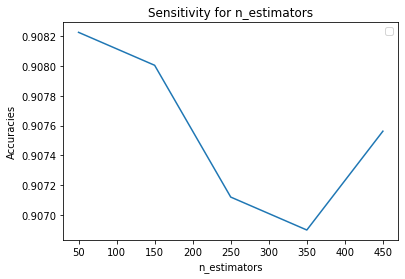

  0%|          | 0/5 [00:00<?, ?it/s]

No handles with labels found to put in legend.


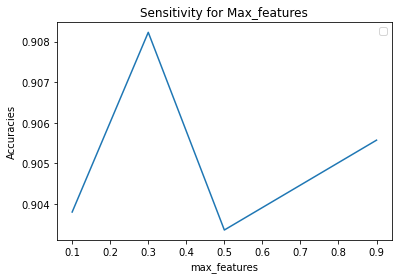

  0%|          | 0/5 [00:00<?, ?it/s]

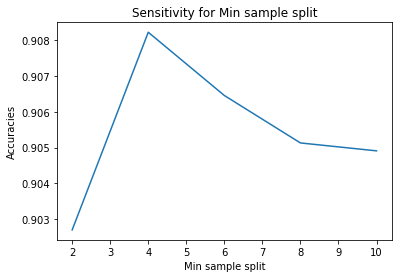

CPU times: user 2min 45s, sys: 92 ms, total: 2min 45s
Wall time: 2min 46s


In [55]:
%%time
part_d_param_senitivity()

In [205]:
print(std_tree_root)
print('total nodes:', std_tree_root.total_nodes)

attr:month     , val:no        , pruned?:0    ,p_checked:1 ,#childs:12   
total nodes: 4196


In [156]:
# ohe_train_data.head()

In [210]:
node_count =0
def count_depth(node, d = 0, count_pruned = True):
    d_s = [d]
    global node_count
    node_count +=1
    if node.prune_below and not count_pruned:
        return d
    for child in node.childs:
        d_local = count_depth(child, d+1, count_pruned)
        d_s.append(d_local)
    return np.max(d_s)
print(count_depth(std_tree_root, count_pruned=False))
print('Node Count',node_count)

7
Node Count 297


In [202]:
def print_tree(node):
    if node.parent == None:
        print('Root->',node.attr,node.split_val_p, node.val, node.sub_tree_size)
    else:
        print('Node:',node.attr, node.split_val_p, node.val, node.sub_tree_size,end = ' ')
    if node.childs == []:
        return 0
    for child in node.childs:
        print_tree(child)
        print('--B--', end = ' ')
        print()
    return 0
#print_tree(tree_root)

In [ ]:
# def main():
    